In [1]:
import os
import sys
import json
from pathlib import Path
sys.path.append(os.path.abspath('..'))


In [2]:
from constants import TRAIN_JSON_PATH

In [3]:

from loguru import logger
import time

from tqdm.auto import tqdm
import numpy as np
from PIL import Image  
import matplotlib.pyplot as plt

import torch
import accelerate
from torch import nn
from torch.nn import functional as F

from  torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from transformers import CLIPTextModel, CLIPTokenizer, CLIPImageProcessor, Dinov2Model

import diffusers
from diffusers import (
    PNDMScheduler, # scheduler
    UNet2DConditionModel, # unet
    AutoencoderKL, # vae
)
# ----------- local imports ----------- 
from FashionDataset import FashionDataset
from ZeroConvNet import ZeroConvNet
from constants import MODELS_SAVE_PATH
from utils import show_images, build_wandb_run
import wandb

DEBUGGING = True
model_save_directory = MODELS_SAVE_PATH / "finetune_f16_cond_as_channel_fashion_16"
model_save_directory.mkdir(exist_ok=True, parents=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("the device used", device)

generator = torch.Generator(device=device).manual_seed(42)
generator_cpu = torch.Generator(device='cpu').manual_seed(42)

# DEBUGGING
# torch.autograd.set_detect_anomaly(True)
    
dtype=torch.bfloat16

batch_size = 4
accumulation_steps = 2
num_epochs = 10
learning_rate = 1e-3
log_every = 8 # 64
save_every = 128
# small_dataset_size = 1024
small_dataset_size = 32

def _get_prompt_embeddings():
    """ get inital prompt embeddings to help model """
    # text encoder components
    tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=dtype)
    text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=dtype)#.to(device)

    prompt = "An ultra high-resolution, photorealistic image in 8K, A highly detailed photo, showcasing vivid colors and rich contrasts, portrait photo, perfect anatomy, 4k, high quality"
    negative_prompt = "nudity (deformed iris, deformed pupils, semi-realistic, cgi, 3d, render, sketch, cartoon, drawing, anime), text, cropped, out of frame, worst quality, low quality, jpeg artifacts, ugly, duplicate, morbid, mutilated, extra fingers, mutated hands, poorly drawn hands, poorly drawn face, mutation, deformed, blurry, dehydrated, bad anatomy, bad proportions, extra limbs, cloned face, disfigured, gross proportions, malformed limbs, missing arms, missing legs, extra arms, extra legs, fused fingers, too many fingers, long neck"
        
    # Tokenize positive and negative prompts
    positive_token_ids = tokenizer(prompt, padding="max_length", truncation=True, return_tensors="pt")['input_ids']#.to(device)
    negative_token_ids = tokenizer(negative_prompt, padding="max_length", truncation=True, return_tensors="pt")['input_ids']#.to(device)

    # Generate embeddings
    with torch.no_grad():
        positive_embeddings = text_encoder(positive_token_ids).last_hidden_state.type(dtype).to(device)
        negative_embeddings = text_encoder(negative_token_ids).last_hidden_state.type(dtype).to(device)

        combined_embeddings = torch.cat([negative_embeddings, positive_embeddings], dim=0)#.type(dtype)
    
    return positive_embeddings, negative_embeddings, combined_embeddings

def get_mask(image_size):
        """ generate grey mask with white for src_img and black for tar_img """
        black_ = torch.full((
                             ), 0, dtype=dtype).to(device)
        white_ = torch.full(image_size, 1, dtype=dtype).to(device)
        
        return torch.cat([white_, black_], dim=1)

        

# ====================== load models ======================
model_id = "SG161222/Realistic_Vision_V6.0_B1_noVAE"

scheduler = PNDMScheduler.from_pretrained(model_id, subfolder="scheduler")
vae_link = "https://huggingface.co/stabilityai/sd-vae-ft-mse-original/vae-ft-mse-840000-ema-pruned.ckpt"

vae = AutoencoderKL.from_single_file(vae_link, torch_dtype=dtype).to(device)
# unet = UNet2DConditionModel.from_pretrained(model_id, subfolder="unet", torch_dtype=dtype).to(device)
# net = ZeroConvNet(unet, in_channels=13, out_channels=4).type(dtype).to(device)


the device used cuda


In [ ]:
net = UNet2DConditionModel.from_pretrained(model_id, subfolder="unet",
                                        in_channels=13,
                                        low_cpu_mem_usage=False,
                                        ignore_mismatched_sizes=True,
                                        torch_dtype=dtype).to(device)

An error occurred while trying to fetch SG161222/Realistic_Vision_V6.0_B1_noVAE: SG161222/Realistic_Vision_V6.0_B1_noVAE does not appear to have a file named diffusion_pytorch_model.safetensors.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


KeyboardInterrupt: 

: 

In [ ]:
checkpoint = torch.load("../models/finetune_f16_cond_as_channel_fashion_16/step_255.pth.tar")


/tmp/ipykernel_2167/2336037655.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("../models/finetune_f16_cond_as_channel_fashion_16/step_255.pth.ta

In [ ]:
net.load_state_dict(checkpoint['model'])

<All keys matched successfully>

In [ ]:
from pathlib import Path
DATA_PATH = Path("../datasets/fashion", absolute=True)
MODELS_SAVE_PATH = Path("./models", absolute=True)

TRAIN_PATH = DATA_PATH / "train_lst_256_png/train_lst_256_png"    
TRAIN_POSES_PATH = DATA_PATH / "train_lst_256_png/poses"    
TRAIN_JSON_PATH = DATA_PATH / "train_data.json"

TEST_PATH = DATA_PATH / "test_lst_256_png/test_lst_256_png"    
TEST_JSON_PATH = DATA_PATH / "train_data.json"
TRAIN_PATH.exists()


/tmp/ipykernel_20169/1429964568.py:2: DeprecationWarning: support for supplying keyword arguments to pathlib.PurePath is deprecated and scheduled for removal in Python 3.14
  DATA_PATH = Path("../datasets/fashion", absolute=True)
/tmp/ipykernel_20169/1429964568.py:3: DeprecationWarning: support for supplying keyword arguments to pathlib.PurePath is deprecated and scheduled for removal in Python 3.14
  MODELS_SAVE_PATH = Path("./models", absolute=True)


True

In [ ]:
positive_embeddings, negative_embeddings, combined_embeddings = _get_prompt_embeddings()
embeddings = positive_embeddings.repeat(batch_size, 1, 1)

train_dataset = FashionDataset(root_dir = TRAIN_PATH, 
                 poses_dir = TRAIN_POSES_PATH,
                 info_json_path = TRAIN_JSON_PATH,
                 small_dataset_size=small_dataset_size)
train_dataloader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, generator=generator_cpu
)

# # Define the optimizer
# optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
# lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
# loss_fn = nn.MSELoss()

# optimizer.zero_grad()

# mask = get_mask((256 // 8, 352 // 16)).unsqueeze(0).unsqueeze(0) #[white, black]
# mask = mask.expand(batch_size, -1, -1, -1)

In [ ]:
inputs = next(iter(train_dataloader))

In [ ]:
src_mask = inputs['src_mask'].type(dtype).to(device)
st_pose = inputs['st_pose'].type(dtype).to(device)
src_tar = inputs['src_tar'].type(dtype).to(device)

In [ ]:
with torch.no_grad():
    # masked_latents
    src_mask_latents = vae.encode(src_mask).latent_dist.sample() * 0.18215
    # latents 
    src_tar_latents = vae.encode(src_tar).latent_dist.sample() * 0.18215 
    
    st_pose_latents = vae.encode(st_pose).latent_dist.sample() * 0.18215 


In [60]:
noise = torch.randn_like(src_tar_latents, device=device, dtype=dtype)
timesteps = torch.randint(0, scheduler.config.num_train_timesteps, (batch_size,), device=device, ).long()
noisy_latents_in = scheduler.add_noise(src_tar_latents, noise, timesteps)
noisy_latents = torch.cat([noisy_latents_in, src_mask_latents, mask, st_pose_latents], dim=1).type(dtype)


with torch.no_grad():
    noise_pred = net(noisy_latents, timesteps, encoder_hidden_states=embeddings).sample
step_output = scheduler.step(noise_pred[0], timesteps[0], noisy_latents_in[0])

In [57]:
loss_fn(step_output.prev_sample, noisy_latents_in[0])

tensor(2.3544e-06, device='cuda:0', dtype=torch.bfloat16)

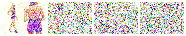

In [58]:
show_images(noisy_latents_in.detach().type(torch.float32))

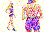

In [ ]:
noise = torch.randn_like(src_tar_latents, device=device, dtype=dtype)
timesteps = torch.randint(0, scheduler.config.num_train_timesteps, (batch_size,), device=device, ).long()
noisy_latents_in = scheduler.add_noise(src_tar_latents, noise, timesteps)
noisy_latents = torch.cat([noisy_latents_in, src_mask_latents, mask, st_pose_latents], dim=1).type(dtype)


with torch.no_grad():
    noise_pred = net(noisy_latents, timesteps, encoder_hidden_states=embeddings).sample
step_output = scheduler.step(noise_pred[0], timesteps[0], noisy_latents_in[0])

In [48]:
noise = torch.randn_like(src_mask_latents, device=device, dtype=dtype)
timesteps = torch.randint(0, scheduler.config.num_train_timesteps, (batch_size,), device=device, ).long()
noisy_latents = scheduler.add_noise(src_mask_latents, noise, timesteps)
# show_images(src_mask_latents.detach().type(torch.float32))
noisy_latents = torch.cat([noisy_latents, src_mask_latents, mask, st_pose_latents], dim=1).type(dtype)


In [49]:
with torch.no_grad():
    noise_pred = net(noisy_latents, timesteps, encoder_hidden_states=embeddings).sample

In [50]:
loss_fn(noise_pred, noise)

tensor(0.5586, device='cuda:0', dtype=torch.bfloat16)

In [ ]:
outputs = scheduler.step(noise_pred[0], timesteps[0], noisy_latents[0])

In [ ]:
noise = torch.randn_like(src_tar_latents, device=device, dtype=dtype)
timesteps = torch.randint(0, scheduler.config.num_train_timesteps, (batch_size,), device=device, ).long()

noisy_latents = scheduler.add_noise(src_tar_latents, noise, timesteps)
noisy_latents = torch.cat([noisy_latents, src_mask_latents, mask, st_pose_latents], dim=1).type(dtype)


  0%|          | 0/51 [00:00<?, ?it/s]

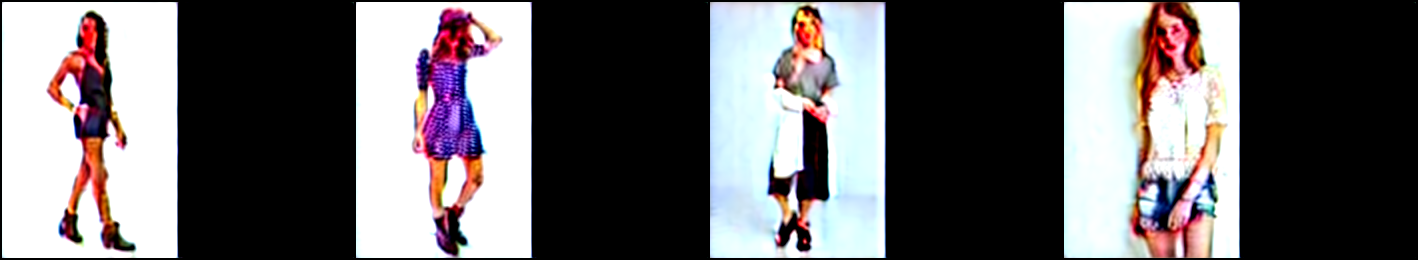

In [ ]:

scheduler.set_timesteps(50)

latents = torch.randn((batch_size, 4, 256 // 8, 352 // 8), generator=generator, device=device, dtype=dtype)

for i, t in tqdm(enumerate(scheduler.timesteps), total=len(scheduler.timesteps)):
    latent_model_input = torch.cat([latents, src_mask_latents, mask, st_pose_latents], dim=1)
    
    with torch.no_grad():
        noise_pred = net(latent_model_input, t, encoder_hidden_states=embeddings).sample
    
    step_output = scheduler.step(noise_pred, t, latents)
    plt.imshow(show_images(step_output.prev_sample.detach().type(torch.float32)))
    plt.title(f"STEP {i}")
    plt.show()
    latents = step_output.prev_sample  # prev_sample (x_t-1)
    # if (i+1) % 10 == 0:
    #     x0 = step_output.pred_original_sample  # x0 estimate
    #     outputs = (1 / 0.18215 * x0)
    #     with torch.no_grad():
    #         outputs = vae.decode(latents).sample
    #     plt.imshow(show_images(outputs.detach().type(torch.float16)))
    #     plt.show()
        
outputs = (1 / 0.18215 * latents)#.clamp(-1, 1)
with torch.no_grad():
    outputs = vae.decode(latents).sample
show_images(outputs.detach().type(torch.float16))


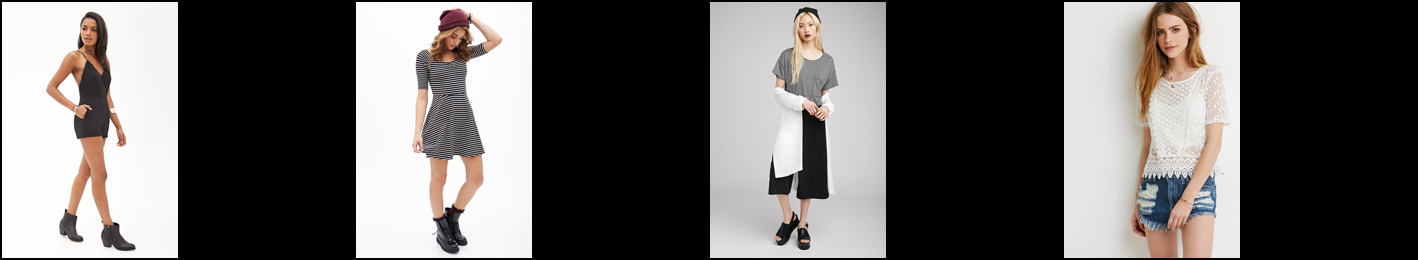

In [63]:
show_images(src_mask.detach().type(torch.float32))

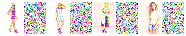

In [78]:
src_mask_latents_noisy = src_mask_latents.detach().clone()


src_mask_latents_noisy[:, :, :, 22:] = torch.randn((batch_size, 4, 256 // 8, 352 // 16), generator=generator, device=device, dtype=dtype)

show_images(src_mask_latents_noisy.detach().type(torch.float32))

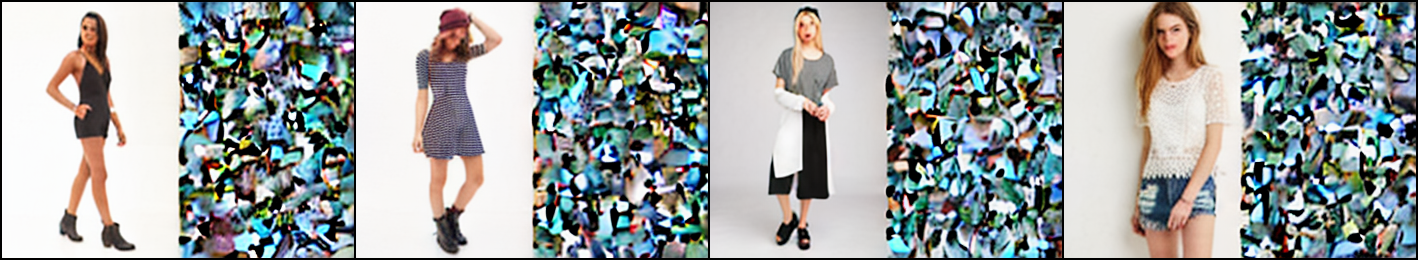

In [80]:
outputs = (1 / 0.18215 * src_mask_latents_noisy)#.clamp(-1, 1)
with torch.no_grad():
    outputs = vae.decode(outputs).sample
show_images(outputs.detach().type(torch.float16))


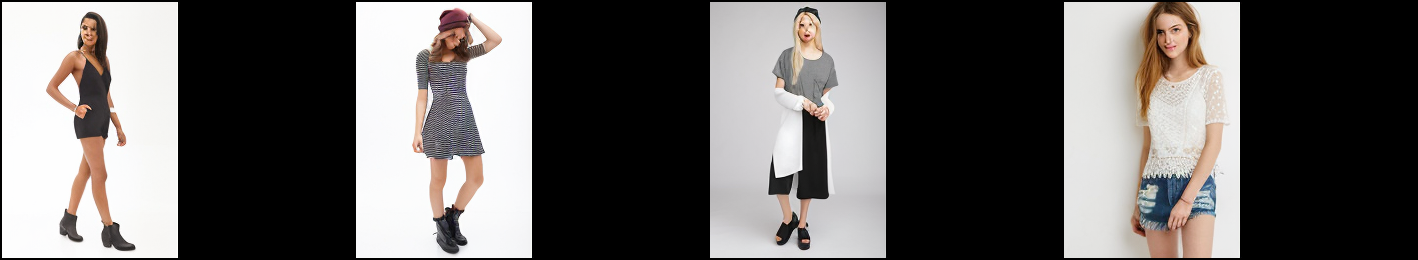

In [19]:
x = src_mask.detach().clone()
with torch.no_grad():
    x_latents = vae.encode(x).latent_dist.sample() * 0.18215
    
outputs = (1 / 0.18215 * x_latents)#.clamp(-1, 1)
with torch.no_grad():
    outputs = vae.decode(outputs).sample
    
show_images(src_mask.detach().type(torch.float32))
show_images(outputs.detach().type(torch.float32))

In [13]:
outputs = (1 / 0.18215 * latents).clamp(-1, 1)
with torch.no_grad():
    outputs = vae.decode(latents).sample

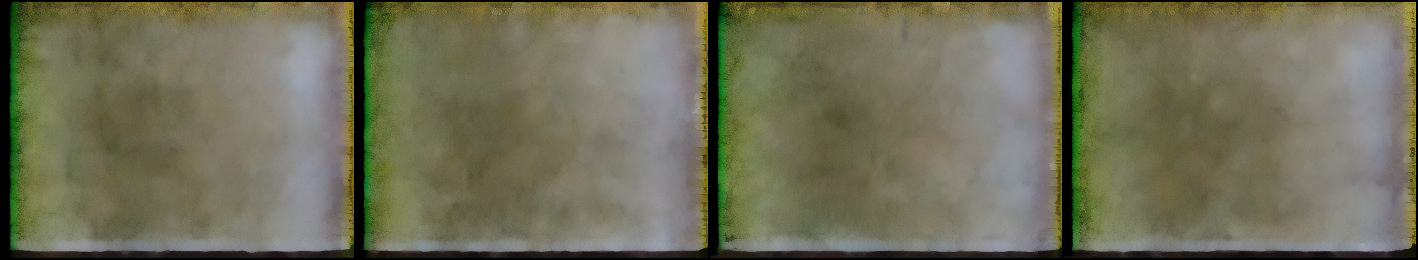

In [14]:
show_images(outputs.detach().type(torch.float16).clamp(-1, 1))

In [15]:
latents.min()

tensor(-13.6875, device='cuda:0', dtype=torch.bfloat16)

In [16]:
list(net.net.named_parameters())

[('0.weight',
  Parameter containing:
  tensor([[[[-0.1953]],
  
           [[-0.1216]],
  
           [[ 0.2773]],
  
           [[-0.2236]],
  
           [[ 0.1050]],
  
           [[ 0.0233]],
  
           [[-0.0933]],
  
           [[-0.2617]],
  
           [[ 0.0171]],
  
           [[ 0.1602]],
  
           [[-0.1133]],
  
           [[-0.1133]],
  
           [[-0.2451]]],
  
  
          [[[ 0.1562]],
  
           [[ 0.0339]],
  
           [[ 0.0620]],
  
           [[-0.0591]],
  
           [[-0.2344]],
  
           [[-0.1143]],
  
           [[-0.1553]],
  
           [[ 0.2480]],
  
           [[ 0.0420]],
  
           [[ 0.1484]],
  
           [[-0.0442]],
  
           [[ 0.1074]],
  
           [[-0.0845]]],
  
  
          [[[ 0.1523]],
  
           [[-0.2734]],
  
           [[-0.1133]],
  
           [[ 0.1406]],
  
           [[-0.2217]],
  
           [[ 0.1699]],
  
           [[ 0.2139]],
  
           [[-0.2031]],
  
           [[-0.2559]],
  
         